# Vorausschauende Instandhaltung

Dieses Notizbuch basiert auf dem github Quellcode-Verzeichnis von Jan Werth: https://github.com/JanderHungrige/PumpSensor

Eine ausführliche Beschreibung ist zu lesen bei Medium: https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210

Der Code wurde von Jascha Grübel für diese Übung adaptiert.

## Vorbereitung von Python in Jupyter

Jupyter läuft in einer separaten Umgebung und greift üblicherweise nicht auf die System Installation von Python zu. Um Packete zu installieren, lohnt es sich diese innerhalb des Notizbuches zu laden. Mehr details können hier gelesen werden: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

### Packet-Installation

TensorFlow ist generell schwierig zu installieren, da es nur mit bestimmten Python-Versionen kompatibel ist. Es ist nötig höchstens Python 3.11 zu installieren, daher bietet sich folgende Installationsanweisung für Jupyter an: https://www.timescale.com/blog/jupyter-notebook-tutorial-setup-python-and-jupyter-notebooks-macos/

In [3]:
import sys
sys.version
sys.path

['/Users/jgruebel',
 '/Users/jgruebel/.pyenv/versions/3.11.2/lib/python311.zip',
 '/Users/jgruebel/.pyenv/versions/3.11.2/lib/python3.11',
 '/Users/jgruebel/.pyenv/versions/3.11.2/lib/python3.11/lib-dynload',
 '',
 '/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages']

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


### Packete importieren

Wir laden mehrere Packete komplett und aus einigen Packeten laden wir nur einzelne Funktionalitäten.

In [2]:
import requests
import zipfile

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import savetxt 

import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from math import sqrt
    
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


### Packete konfigurieren

Für die anschauliche Visualisierung vergrössern wir die Figuren.

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]

## Datenbereitstellung

Die Daten können hier heruntergeladen werden: https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip

Die Daten müssen neben dem Notizbuch im selben Ordner abgelegt werden, um von Jupyter geladen werden zu können.

### Daten herunterladen

In [3]:
url = 'https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip'

response = requests.get(url, stream=True)
with open('pump_sensor.zip', "wb") as f:
    for chunk in response.iter_content(chunk_size=512):
        if chunk:  # filter out keep-alive new chunks
            f.write(chunk)

### Daten einlesen

In [6]:
with zipfile.ZipFile('pump_sensor.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
def daten_lesen(path):
    daten=pd.read_csv(path)
    senornamen=daten.keys()[2:-1] #geht beides
    return daten, senornamen

daten,sensor_namen=daten_lesen('pump_sensor.csv')

## Datenübersicht

Zuerst werden grobe Details der Daten überprüft. Dies ist wichtig, um später beurteilen zu können, ob Daten sich wie erwartet transformieren oder ob wir einen Fehler begangen haben.

Wir explorieren die Sensordaten, sowie die Status-Zustände, die wir von der Pumpe erhalten können. 

In [8]:
def daten_explorieren(daten):
    print('Datenübersicht: ')
    print(daten.shape); print()
    print('Schlüssel :') ; print(daten.keys()); print()
    print( 'Statusoptionen: ');  print( daten['machine_status'].unique()); print()
    print (daten['machine_status'].value_counts()); print()
    #print((data.isna().sum())[2:-1]); print()
    info=daten.describe()
    varianz=pd.DataFrame({'Var':daten.iloc[:,2:-1].var()})
    info=pd.concat([info,varianz.transpose()])
    return daten.head(), daten.tail(), info

Kopf,Schwanz, information=daten_explorieren(daten)

Datenübersicht: 
(220320, 55)

Schlüssel :
Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

Statusoptionen: 
['NORMAL' 'BROKEN' 'RECOVERING']

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: 

Ein kurzer Blick auf den Kopf der Daten gibt uns eine Übersicht, was wir zu erwarten haben.

In [9]:
Kopf

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Wir wiederholen den Vorgang für den Schwanz der Daten, um eine vorläufige Gesamtübersicht zu bekommen.

In [10]:
Schwanz

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.28703,52.37268,48.32176,41.087960,212.3843,153.6458,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.84028,50.63657,48.03241,40.798610,213.8310,156.2500,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


## Rohdaten-Visualisierung

Um die Visualisierung der Rohdaten zu ermöglichen, benötigen wir einige Plot-Funktionen.

In [11]:
def plot_helfer(daten,plot_type,titel, abspeichern=False,axis = None,ohne_legende=False):
    if axis is None:
        fig=plt.figure()
        daten.plot(kind=plot_type)
        plt.title(titel)
    else:
        daten.plot(kind=plot_type,ax=axis)
        if ohne_legende: 
            axis.get_legend().remove()
    if abspeichern==True:
        plt.savefig(titel+'.png', format='png', dpi=300, transparent=True)  
    
def plotting_merged(data, encoded_y, senorname, saving=False):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_dat = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    for i in senorname:
        fig=plt.figure()
        ax=scaled_dat[i].plot.line()
        encoded_y.plot(ax=ax)
        plt.title('together_' + str(i) )
        plt.legend(['sensor','target'])
        if saving==True:
            fig.savefig('Sensor_'+str(i)+'.png', format='png', dpi=300, transparent=True)
        plt.show()    

def plotting_together(Values): 
    fig=plt.Figure()
    Values.plot(subplots = True, sharex = True, figsize=(30,55))    
    plt.savefig('Overview.png', format='png', dpi=300, transparent=True)
    plt.show()      
    
def plot_Zielfunktion(daten, spalte='target', abspeichern=False, name='target'):
    y=daten[spalte]; x=np.linspace(1,len(y),len(y))
    plt.plot(x,y)
    plt.ylabel('Klasse')
    plt.title('Zielfunktion')
    labels = ['Normal','Kaputt','Wiederherstellung']
    if spalte=='target':
        plt.yticks([1,0,2], labels, rotation='vertical')
    elif spalte=='machine_status':
        plt.yticks([0,1,2], labels, rotation='vertical')
    if abspeichern==True:
        plt.savefig(name+'.png', format='png', dpi=300, transparent=True)
    plt.show()   

### Zielfunktion
Wir schauen uns nun dei Zielfunktion an, die es zu vorhersagen gilt.  Es fällt auf, dass die "Kaputt"-Klasse fast nie vorkommt, sehr wohl aber die Wiederherstellung der Funktionalität nach dem "kaputtgehen".

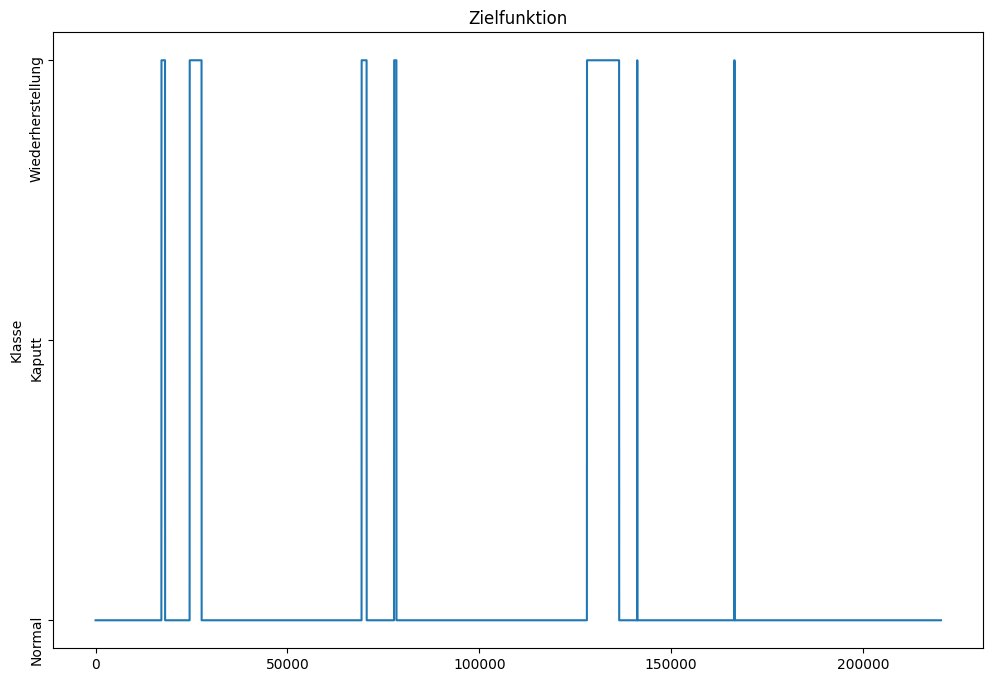

In [12]:
plot_Zielfunktion(daten,spalte='machine_status',abspeichern=False,name='Klassen')

### Datenqualität
Wir versuchen nun aufgrund von "NaN"-Zuständen, Standardabweichungen und Varianz die Qualität der Daten einzuordnen. Dies ist wichtig, da Maschinelles Lernen am besten mit einem guten Signal funktioniert und durch Rauschen und Fehler in den Daten starke Leistungseinbussen hinnehmen muss.

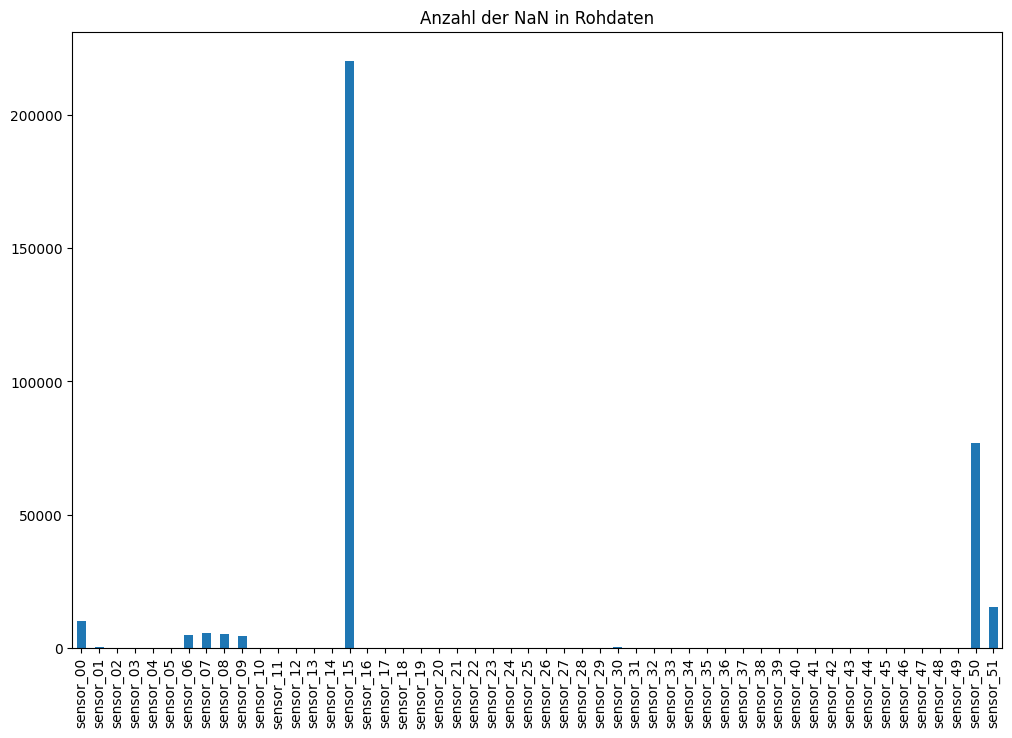

<Figure size 1200x800 with 0 Axes>

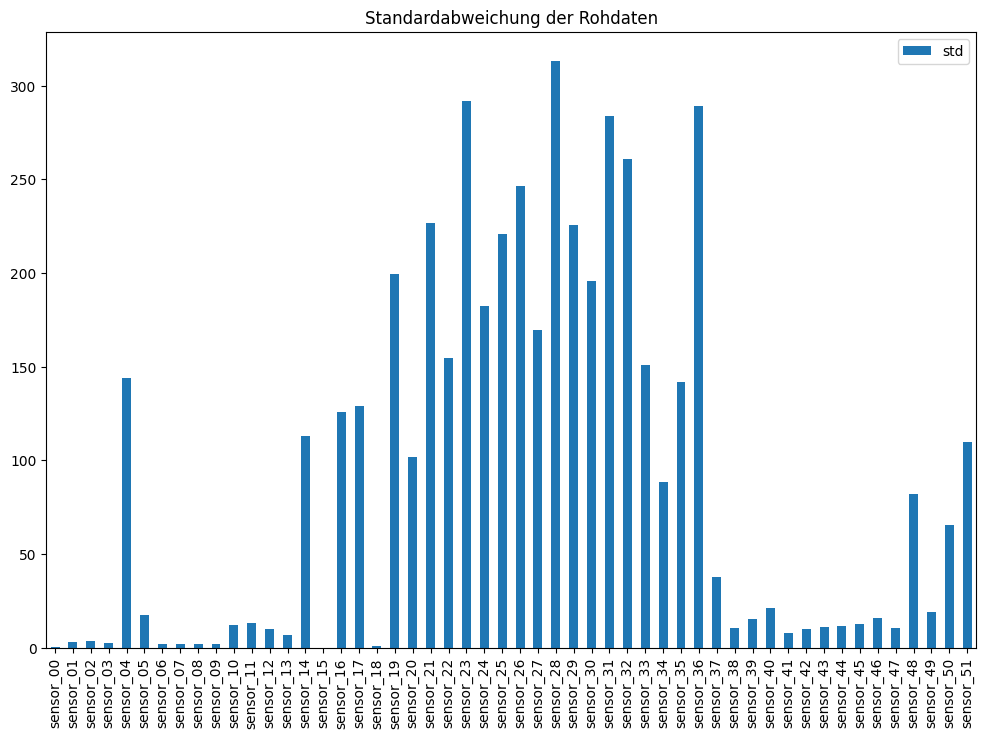

<Figure size 1200x800 with 0 Axes>

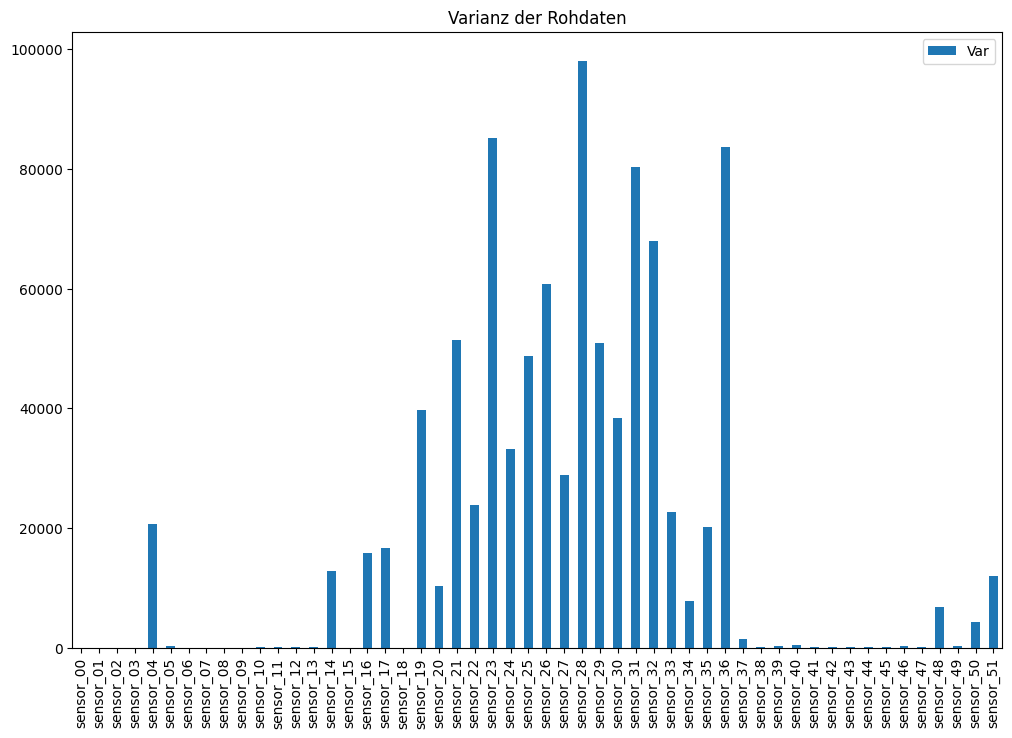

In [13]:
plot_helfer((daten.isna().sum())[2:-1],'bar','Anzahl der NaN in Rohdaten',abspeichern=False) 
plot_helfer(information.loc[['std']][sensor_namen].transpose(),'bar','Standardabweichung der Rohdaten',abspeichern=False)
plot_helfer(information.loc[['Var']][sensor_namen].transpose(),'bar','Varianz der Rohdaten',abspeichern=False)

### Daten-Reparatur (data wrangling)

Um die Daten zu reparieren, müssen wir die Anzahl der NaN minimieren und die Varianz der Daten maximieren. Alle NaNs zu verwerfen würde zu zu grossem Datenverlust führen.

Sensor 00, 06,07,08, 09 und 15 haben viele NaNs und keine Varianz und können daher sorglos entfernt werden.

Sensor 50 und 51 haben Varianz und müssen daher genauer betrachtet werden:

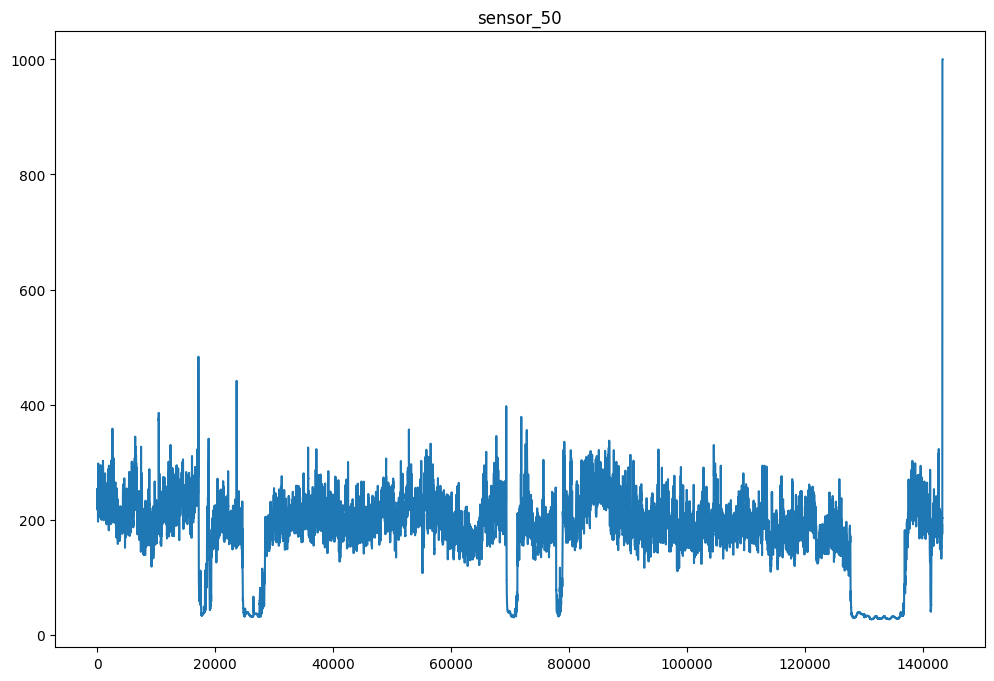

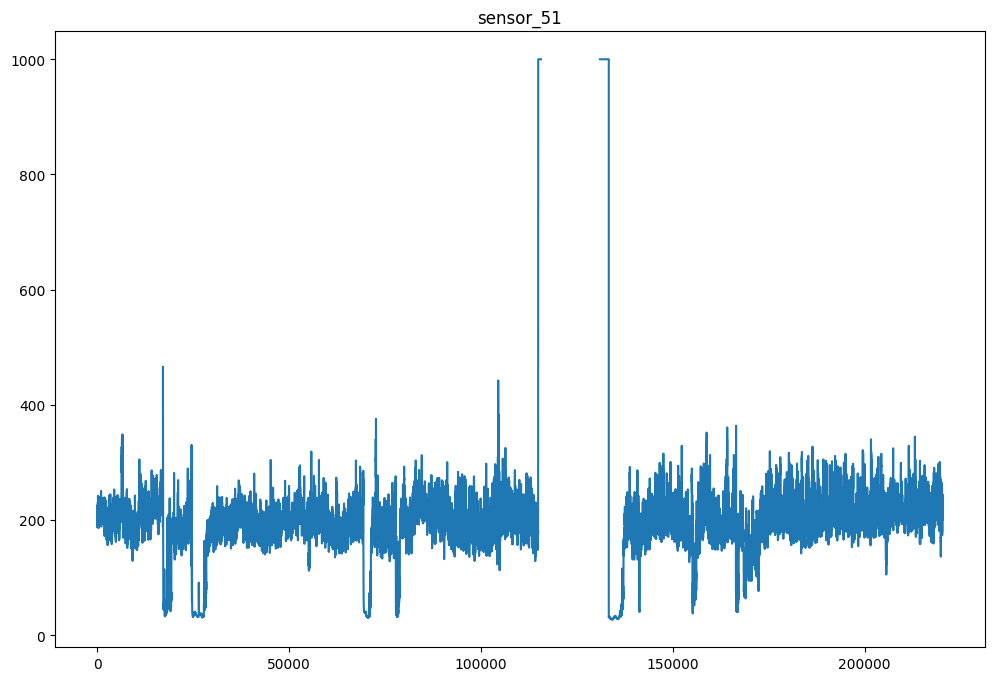

In [14]:
for i in ['sensor_50','sensor_51']:
         plot_helfer(daten[i],'line',str(i))

Es gibt einen Datenverlust zwischen 110000 und 140000 in Sensor 51 sowie einen totalverlust in sensor 50 ab 145000.

Wir vergrössen der Ausschnitt des Datenverlusts für eine nähere Beobachtung:

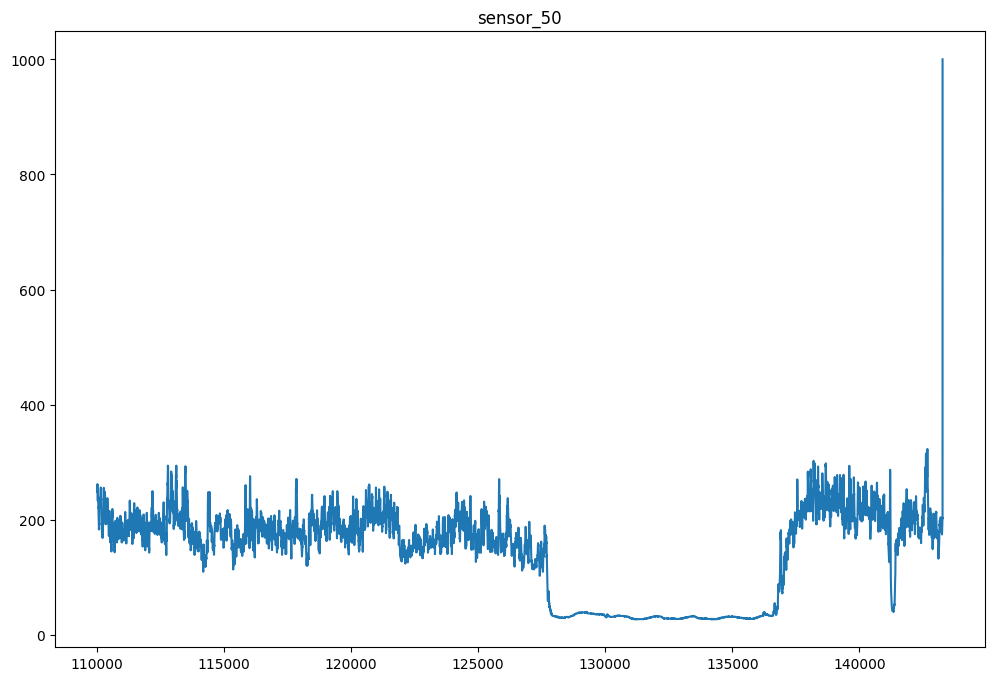

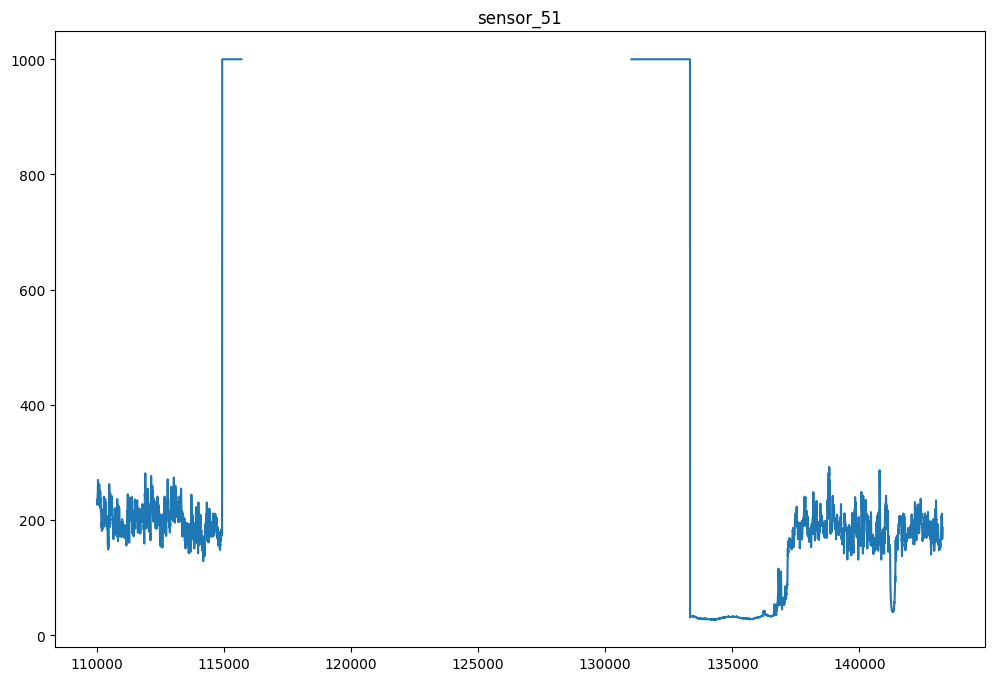

In [15]:
for i in ['sensor_50','sensor_51']:
         plot_helfer(daten[i][110000:143279],'line',str(i))

Sensor 50 und 51 scheinen ein sehr ähnliches Signal zu haben. Um die maximale Varianz für das Maschinelle Lernen aus den Daten zu extrahieren bietet es sich an den Sensor 51 mit Daten aus 50 zu reparieren und danach den Sensor 50 zu verwerfen. Vermerk: loc ist eckigen Klammern zu bevorzugen, da es effizienter ist und keine Kopien produziert.

Zu guter letzt lohnt es sich durch "Auffüllen" kurze NaNs-Reihen in den Daten, die typischerweise durch Unterbrechung von Datenübertragung entstehen können, zu reparieren.

Unnamed: 0        0
timestamp         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0
sensor_51         0
machine_status    0
dtype: int64


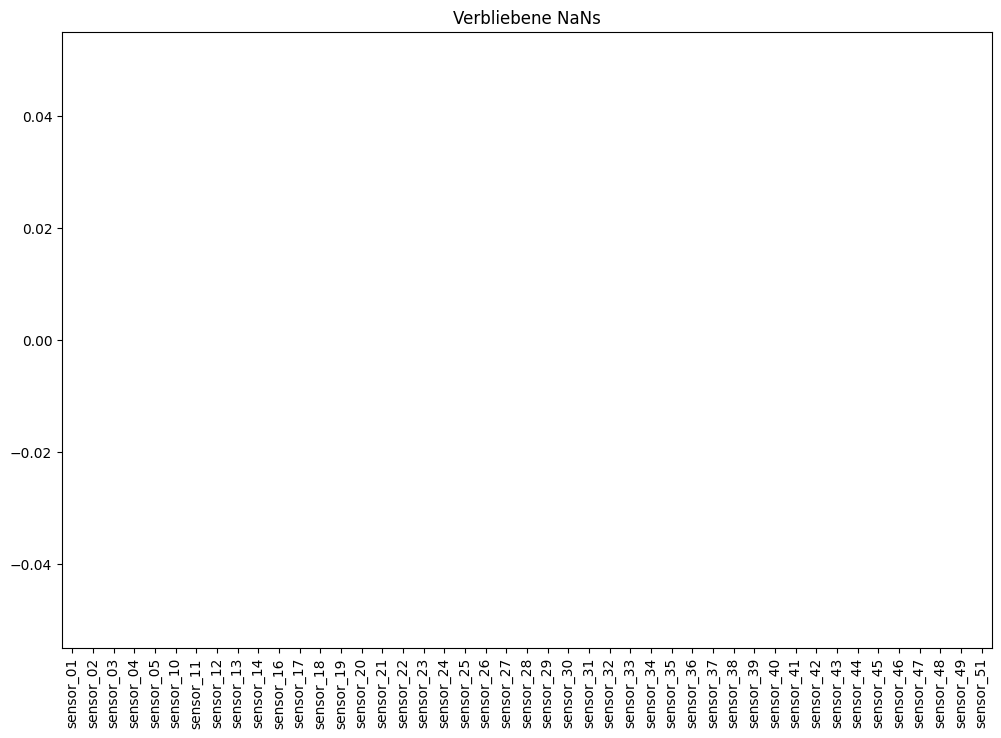

In [16]:
def daten_reparatur(daten, plotten=False):
    
    daten.iloc[114900:135000,[53]]=daten.iloc[114900:135000,[52]]
    daten=daten.drop(labels=['sensor_00','sensor_06','sensor_07','sensor_08','sensor_09','sensor_15','sensor_50'],axis=1)

    
    daten=daten.ffill(limit=30)
    daten=daten.dropna()
    if plotten==True:
        print((daten.isna().sum()))
        plot_helfer((daten.isna().sum()[2:-1]),'bar','Verbliebene NaNs',abspeichern=False)
        
    return daten

reparierte_daten = daten_reparatur(daten, plotten=True)

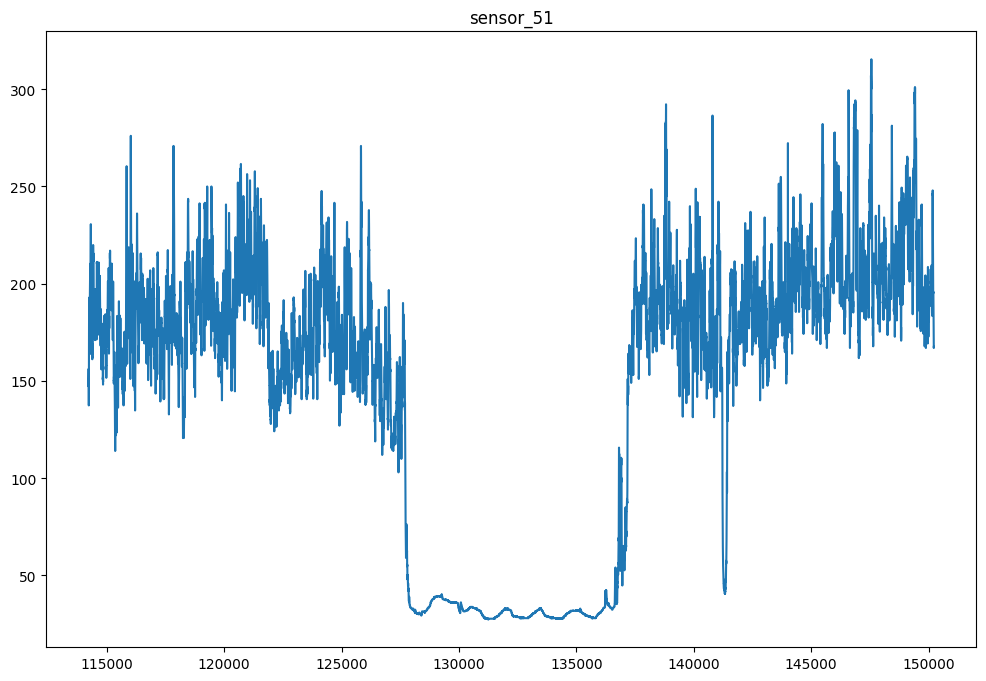

In [17]:
plot_helfer(reparierte_daten['sensor_51'][114000:150000],'line',str(i))

Wir können sehen, dass nun keine NaNs mehr übrig sind und Sensor 51 über kein grosses Loch mehr erfügt. Die Auswahl der Methoden für das Reparieren von Daten ist eine Kunst und keine Wissenschaft. Es bedarf viel Erfahrung, um nicht künstliche Signale zu erzeugen.

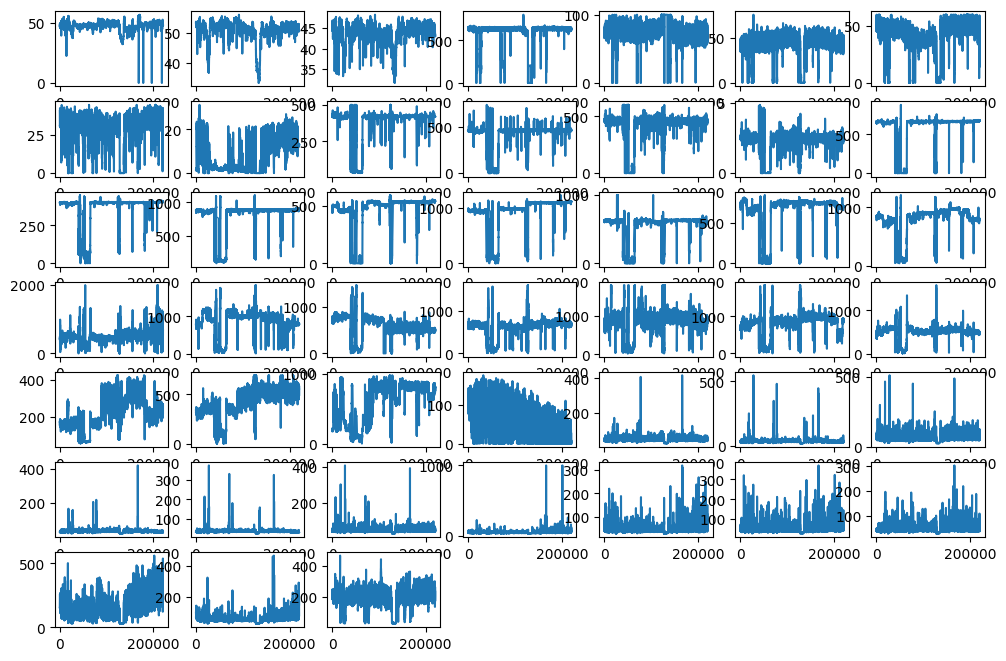

In [18]:
fig, axes = plt.subplots(nrows=7, ncols=7)
visualisierungs_daten = reparierte_daten.drop(labels=['Unnamed: 0','timestamp','machine_status'],axis=1)
for j in range(7):
    for k in range(7):
        if (j*7+k<45):
            plot_helfer(visualisierungs_daten.iloc[:,j*7+k],'line',visualisierungs_daten.iloc[:,j*7+k].name,axis = axes[j,k])
for ax in axes[6,3:7]:
    ax.set_axis_off()

Hier sehen wir nun eine Übersicht der Rohdaten nach der Reparatur.

# Daten kodieren

Klassen müssen generell für Maschinelles Lernen zu Zahlen konvertiert werden.

{'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


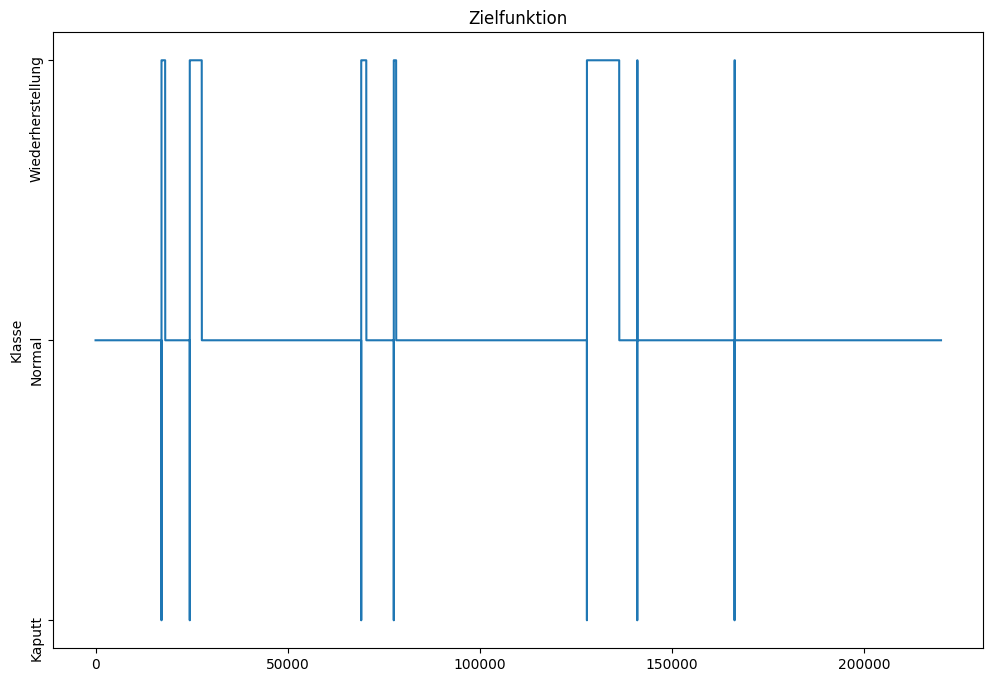

In [19]:
def Vorverarbeitung_Y(data):
    #Label Mapping
    le = preprocessing.LabelEncoder()
    le.fit(data)
    encoded_y=le.transform(data)
    #Get the Label map
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    return pd.DataFrame(encoded_y,columns=['target'])

kodiertes_Y=Vorverarbeitung_Y(reparierte_daten['machine_status']);

plot_Zielfunktion(kodiertes_Y,spalte='target', abspeichern=True , name='Klassen')

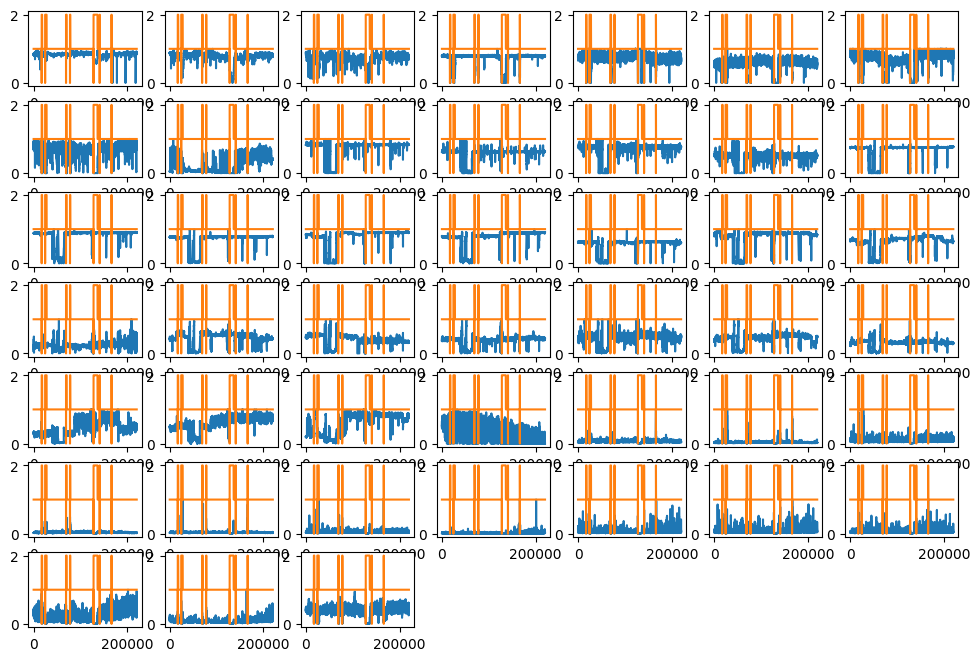

In [20]:
fig, axes = plt.subplots(nrows=7, ncols=7)
skalier = MinMaxScaler()
skalierte_daten = pd.DataFrame(skalier.fit_transform(visualisierungs_daten), columns=visualisierungs_daten.columns)
for j in range(7):
    for k in range(7):
        if (j*7+k<45):
            plot_helfer(skalierte_daten.iloc[:,j*7+k],'line',skalierte_daten.iloc[:,j*7+k].name,axis = axes[j,k])
            plot_helfer(kodiertes_Y,'line',skalierte_daten.iloc[:,j*7+k].name,axis = axes[j,k],ohne_legende = True)

for ax in axes[6,3:7]:
    ax.set_axis_off()

# Vorhersage für Vorausschauende Instandhaltung

Objekt-Orientiertes Programmieren (OOP) hat den Vorteil, dass repetitive Schritte auf ähnlichen Objekten generalisiert werden können und vereinfacht dargestellt werden könnnen.

Im ersten Teil dieser Übung wurden einfache Funktionen geschrieben, um Aufgaben zusammenzufassen. OOP verschiebt den Fokus von was die Aufgabe ist zu "für was" die Aufgabe ist. Im folgenden werden wir Objekte für Zeitreihen und Datensätze verwenden, um Funktionen an diese Objekte zu binden und komplizierte Programme als einfache Funktionsaufrufe auszuführen.

### Klasse für Daten

In [21]:
class Daten:
    def __init__(self, data_x, data_y, LSTM = False, OneHot = False):
        self.data_x=data_x
        self.data_y=data_y
        self.encoded_y=[]
        if (OneHot):
            self.one_hot()
        if (LSTM):
            self.scaling()
            self.reshape_for_Lstm()
        
    def Vorverarbeitung_Y(self):
        le = preprocessing.LabelEncoder()
        le.fit(self.data_y)
        self.data_y=le.transform(self.data_y)
        self.data_y=pd.DataFrame(self.data_y,columns=['target'])          
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

    def splitting(self, von, bis, LSTM = True, OneHot = True):    
        split_x=self.data_x[von:bis].values
        split_y=self.data_y[von:bis].values
        return Daten(split_x, split_y,LSTM, OneHot)

    def make_float(self):      
        self.data_x.astype('float32')

    def reshape_for_Lstm(self):   
        timesteps=1
        samples=int(np.floor(self.data_x.shape[0]/timesteps))   
        self.data_x=self.data_x.reshape((samples,timesteps,self.data_x.shape[1]))   

    def one_hot(self):
        oneHot=OneHotEncoder()
        oneHot.fit(self.data_y.reshape(-1,1))
        self.oneHot=oneHot.transform(self.data_y.reshape(-1,1)).toarray()
       # return self.data_y
    
    def scaling(self,save=False):
        scaler=MinMaxScaler().fit(self.data_x)
        self.data_x=scaler.transform(self.data_x) 
        if save:
            savetxt('test_x_data_OOP.csv',self.data_x,delimiter='.')

### Klasse für Zeitreihe

In [27]:
class Zeitreihe:
    def __init__(self,data, n_in=1, n_out=1):
        self.data=data
        self.n_in=n_in
        self.n_out=n_out
    
    def series_to_supervised(self,dropnan=True):
        n_vars = 1 if type(self.data) is list else self.data.shape[1]
        df = pd.DataFrame(self.data)
        cols, namen = list(),list()
        # input sequence (t-n, ... t-1)
        for i in range(self.n_in, 0, -1):
            cols.append(df.shift(i))
            namen +=[('sensor%d(t-%d)' %(j+1, i)) for j in range (n_vars)]
            #forecast sequence (t, t+1, ... t+n)
        for i in range(0, self.n_out):
            cols.append(df.shift(-i))
            if i == 0:
                namen +=[('sensor%d(t)' %(j+1)) for j in range (n_vars)]
            else:
                namen +=[('sensor%d(t+%d)' %(j+1, i)) for j in range (n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns=namen
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
            
        self.data=self.clean_series_to_supervised(agg)
        
        return self.data
    
    def clean_series_to_supervised(self,shifted_data):
        to_remove_list =['sensor'+str(n)+'(t)' for n in range(1,len(self.data.columns)+1)] #now remove all non shifted elements again. so we retreive elements and shifted target
        #to_remove_list_2 =['sensor'+str(n)+'(t-'+ str(i)+')' for n in range(1,len(data_scaled.columns)+1) for i in range(1,Future)] #now remove all non shifted elements again. so we retreive elements and shifted target
        #to_remove_list=to_remove_list_1+to_remove_list_2
        data_y=shifted_data.iloc[:,-1] #Get the target data out before removing unwanted data
        data_x=shifted_data.drop(to_remove_list, axis=1) #remove sensors(t)
        data_x.drop(data_x.columns[len(data_x.columns)-1], axis=1, inplace=True)# remove target(t-n)
        data=pd.concat([data_x,data_y],axis=1)
        data.columns=[*data.columns[:-1],'machine_status'] # rename last column to target name
        return data

## Klasse für Künstliche Intelligenz

In [131]:
class KI:
    def __init__(self, rohdaten, kodiertes_y, vorhersage_zeitpunkt):
        """
        Die Künstliche Intelligenz wird mit mehreren Parametern intialisiert, um Vorrausschauende Instandhaltung zu implementieren.
        rohdaten: Sensordaten, die in Zeitreihen verwandelt werden sollen.
        vorhersage_zeitpunkt: Wie viele Zeitpunkte in die Zukunft, dass Modell vorhersagen soll.
        """
        self.Rohdaten = pd.concat([rohdaten,kodiertes_y],axis=1)
        self.Vorhersage_Zeitpunkt = vorhersage_zeitpunkt
        self.Zeitreihe = Zeitreihe(self.Rohdaten,self.Vorhersage_Zeitpunkt).series_to_supervised()
        self.Zeitreihen_Sensornamen=self.Zeitreihe.keys()[:-1]

        #PREPROCESS DATA
        self.Daten=Daten(self.Zeitreihe[self.Zeitreihen_Sensornamen], self.Zeitreihe['machine_status']) #Create class instance of Data
        self.Daten.Vorverarbeitung_Y() # change Y to mapped target values
        self.Daten.make_float()
        
        self.Train_data = self.Daten.splitting(0,120000)
        self.Val_data = self.Daten.splitting(140000,len(self.Daten.data_x))
        self.Test_data = self.Daten.splitting(120000,140000)


        self.Modell=self.LSTM_Modell_bauen()
        
        self.Modell.compile(loss={'signal_out':'mean_squared_error',
                            'class_out' :'categorical_crossentropy'},
                             optimizer='adam',
                             metrics={'class_out':'acc'})



    def LSTM_Modell_bauen(self):
        in_shape = (self.Train_data.data_x.shape)
        inputs= tf.keras.Input(shape=(in_shape[1],in_shape[2]))
        x=LSTM(42,activation='relu', input_shape=(in_shape[1],in_shape[2]),return_sequences=True)(inputs)
        x=LSTM(42,activation='relu')(x)
        out_signal=Dense(1, name='signal_out')(x)
        out_class=Dense(3,activation='softmax', name='class_out')(x)
        return tf.keras.Model(inputs=inputs, outputs=[out_signal,out_class])
    
    def plot_training(self,what='loss',saving=False,name='training'):
        fig=plt.figure()
        plt.plot(self.history.history['class_out_'+what])
        plt.plot(self.history.history['val_class_out_'+what])
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])
        if what=='loss':
            plt.title('model loss')
            plt.ylabel('loss')
        elif what=='acc':   
            plt.title('model Acc')
            plt.ylabel('Accuracy')   
        if saving==True:
            fig.savefig( name +'_'+ what + '.png', format='png', dpi=300, transparent=True)
    
    
        plt.xlabel('epoch')
        plt.legend(['train', 'test'])
        if saving==True:
            fig.savefig( name +'_ACC.png', format='png', dpi=300, transparent=True)  
        plt.show()
        
    def plot_signal_hat(self, saving=False, type= 'LSTM', name='results_signal', axis = None):
        if type == 'LSTM':
            yhat = self.YHat
        elif type == 'RF':
            yhat = self.RFR_modell.predict(self.Test_data.data_x.reshape(-1, self.Test_data.data_x.shape[2]))
        
        if axis is None:
            fig= plt.figure()
            plt.plot(self.Test_data.data_y)
            plt.plot(yhat)
            plt.legend(['target','target_predicted'])
            plt.ylabel('Zustand')
            plt.title('Vorhersage des Signals auf Testdaten für ' + name)
        else:
            axis.plot(self.Test_data.data_y)
            axis.plot(yhat)
            axis.legend(['target','target_predicted'],title = "Signal " + name)
        
        if axis is None:
            if saving==True:
                fig.savefig( name +'.png', format='png', dpi=300, transparent=True)
            plt.show()

    def plot_class_hat(self, saving=False, type= 'LSTM', name='results_class', axis = None):   
        if type == 'LSTM':
            yhat = self.YClass
        elif type == 'RF':
            yhat = self.RFC_modell.predict(self.Test_data.data_x.reshape(-1, self.Test_data.data_x.shape[2]))
        
        if axis is None:
            fig= plt.figure()
            plt.plot(self.Test_data.data_y)
            plt.plot(yhat)
            plt.legend(['target','target_predicted'])
            plt.ylabel('Zustand')
            plt.title('Vorhersage der Klasse auf Testdaten für ' + name)
        else:
            axis.plot(self.Test_data.data_y)
            axis.plot(yhat)
            axis.legend(['target','target_predicted'],title = "Klasse " + name)
        
        if axis is None:
            if saving==True:
                fig.savefig( name +'.png', format='png', dpi=300, transparent=True)
            plt.show()

    def LSTM_modell_trainieren(self, modell_name,epoch = 20, batchsize = 32, modell_laden = False, plot_zeigen = True):   
        if modell_laden:
            self.Modell=tf.keras.models.load_model('./model/'+modell_name)
        else:  
            self.history = self.Modell.fit(self.Train_data.data_x, [self.Train_data.data_y, self.Train_data.oneHot], epochs=epoch, batch_size=batchsize, validation_data=(self.Val_data.data_x, [self.Val_data.data_y,self.Val_data.oneHot]), shuffle=False)
            if plot_zeigen:
                self.plot_training(what='loss',
                              saving=True,
                              name=('training_'+ str(self.Vorhersage_Zeitpunkt)))  
                self.plot_training(what='acc',
                              saving=True,
                              name=('training_'+ str(self.Vorhersage_Zeitpunkt))) 
            self.Modell.save('./model/'+str(modell_name))

    def Random_forest_modell_trainieren(self,num_trees = 100, epoch = 1, modell_laden = False, plot_zeigen = True):   
        self.RFR_modell = RandomForestRegressor(n_estimators = num_trees, n_jobs=-1, warm_start = True, max_features = 0.33, verbose = 2)
        for i in range(epoch):
            self.RFR_modell.fit(self.Train_data.data_x.reshape(-1, self.Test_data.data_x.shape[2]), self.Train_data.data_y.ravel())
            self.y_pred_rfr = self.RFR_modell.predict(self.Val_data.data_x.reshape(-1, self.Val_data.data_x.shape[2]))
            cm = confusion_matrix(self.Val_data.data_y.ravel(), np.round(self.y_pred_rfr))
            accuracy = accuracy_score(self.Val_data.data_y.ravel(), np.round(self.y_pred_rfr))
            precision = precision_score(self.Val_data.data_y.ravel(), np.round(self.y_pred_rfr), average = 'weighted')
            recall = recall_score(self.Val_data.data_y.ravel(), np.round(self.y_pred_rfr), average = 'weighted')
            print("Confusion Matrix:", cm)
            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)

        
        self.RFC_modell = RandomForestClassifier(n_estimators = num_trees, n_jobs=-1, warm_start = True, max_features='sqrt', verbose = 2)
        
        for i in range(epoch):
            self.RFC_modell.fit(self.Train_data.data_x.reshape(-1, self.Test_data.data_x.shape[2]), self.Train_data.data_y.ravel())
            self.y_pred_rfc = self.RFC_modell.predict(self.Val_data.data_x.reshape(-1, self.Val_data.data_x.shape[2]))
            cm = confusion_matrix(self.Val_data.data_y.ravel(), self.y_pred_rfc)
            accuracy = accuracy_score(self.Val_data.data_y.ravel(), self.y_pred_rfc)
            precision = precision_score(self.Val_data.data_y.ravel(), self.y_pred_rfc, average = 'weighted')
            recall = recall_score(self.Val_data.data_y.ravel(), self.y_pred_rfc, average = 'weighted')
            print("Confusion Matrix:", cm)
            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)

    def modellzusammenfassung(self):
        self.Modell.summary()

    def vorhersagen(self):
        [yhat,yclass] = self.Modell.predict(self.Test_data.data_x)  
        self.YHat = yhat
        self.YClass=[np.argmax(yclass[i],0) for i in range(len(yclass))] # get final class
        
        cm = confusion_matrix(self.Test_data.data_y.ravel(), np.round(self.YHat))
        accuracy = accuracy_score(self.Test_data.data_y.ravel(), np.round(self.YHat))
        precision = precision_score(self.Test_data.data_y.ravel(), np.round(self.YHat), average = 'weighted')
        recall = recall_score(self.Test_data.data_y.ravel(), np.round(self.YHat), average = 'weighted')
        print("Confusion Matrix:", cm)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)

        
        cm = confusion_matrix(self.Test_data.data_y.ravel(), np.array(self.YClass))
        accuracy = accuracy_score(self.Test_data.data_y.ravel(), np.array(self.YClass))
        precision = precision_score(self.Test_data.data_y.ravel(), np.array(self.YClass), average = 'weighted')
        recall = recall_score(self.Test_data.data_y.ravel(), np.array(self.YClass), average = 'weighted')
        print("Confusion Matrix:", cm)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
            

## Vorhersage

In [116]:
Vorrausschauende_Instandhaltungs_KI2.Test_data.data_x.shape[2]

1379

### LSTM

{0.0: 0, 1.0: 1, 2.0: 2}
Epoch 1/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.1793 - signal_out_loss: 0.0479 - class_out_loss: 0.1314 - class_out_acc: 0.9635 - val_loss: 0.0245 - val_signal_out_loss: 0.0035 - val_class_out_loss: 0.0210 - val_class_out_acc: 0.9985
Epoch 2/40
3750/3750 [==============================] - 6s 2ms/step - loss: 0.2082 - signal_out_loss: 0.0301 - class_out_loss: 0.1781 - class_out_acc: 0.9478 - val_loss: 0.0156 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0141 - val_class_out_acc: 0.9985
Epoch 3/40
3750/3750 [==============================] - 6s 2ms/step - loss: 0.2219 - signal_out_loss: 0.0303 - class_out_loss: 0.1916 - class_out_acc: 0.9502 - val_loss: 0.0173 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0158 - val_class_out_acc: 0.9985
Epoch 4/40
3750/3750 [==============================] - 6s 2ms/step - loss: 0.2207 - signal_out_loss: 0.0315 - class_out_loss: 0.1892 - class_out_acc: 0.9502 - val_loss: 0.0183 - val_

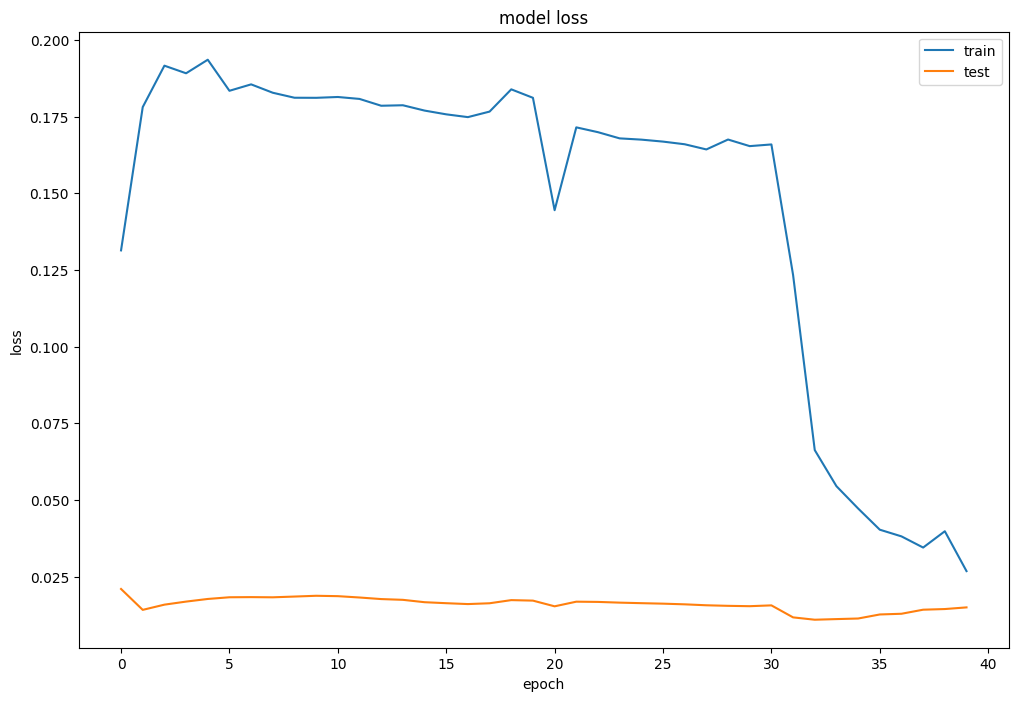

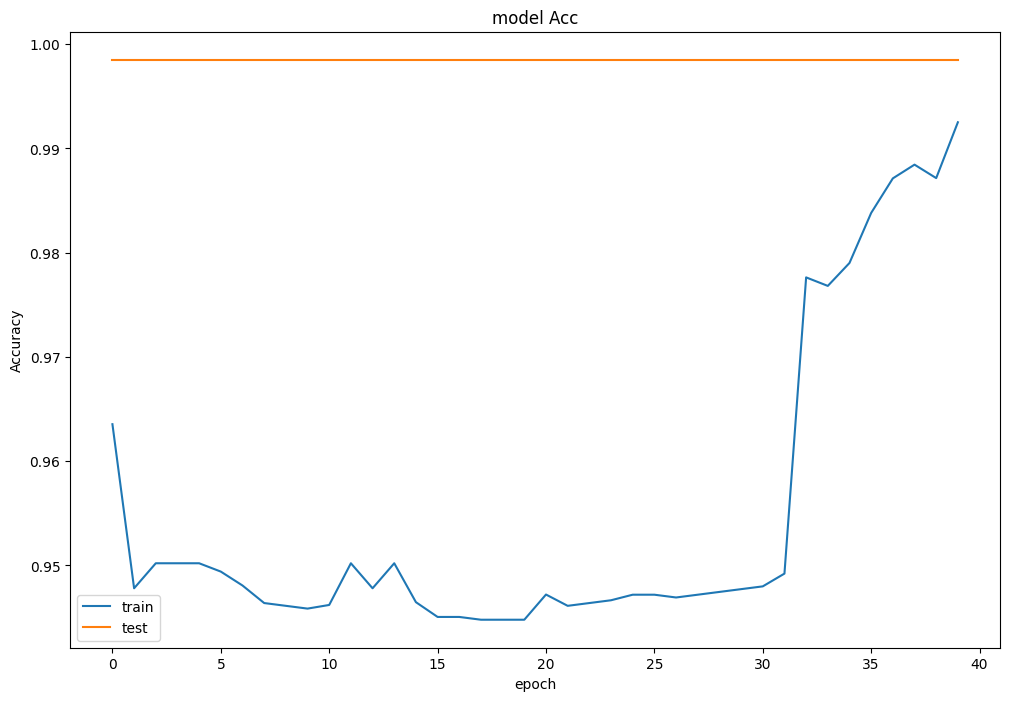

INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F10/assets


INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F10/assets


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 1, 459)]             0         []                            
                                                                                                  
 lstm_48 (LSTM)              (None, 1, 42)                84336     ['input_25[0][0]']            
                                                                                                  
 lstm_49 (LSTM)              (None, 42)                   14280     ['lstm_48[0][0]']             
                                                                                                  
 signal_out (Dense)          (None, 1)                    43        ['lstm_49[0][0]']             
                                                                                           

/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
Vorrausschauende_Instandhaltungs_KI = KI(rohdaten = visualisierungs_daten, kodiertes_y = kodiertes_Y, vorhersage_zeitpunkt = 10)

Vorrausschauende_Instandhaltungs_KI.LSTM_modell_trainieren(modell_name = "Pump_LSTM_F10",epoch=40)

print(Vorrausschauende_Instandhaltungs_KI.modellzusammenfassung())

Vorrausschauende_Instandhaltungs_KI.vorhersagen()
   

### Random Forest

In [135]:
Vorrausschauende_Instandhaltungs_KI.Random_forest_modell_trainieren()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.9s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: [[    0     2     0]
 [    0 79373     5]
 [    0     2   114]]
Accuracy: 0.9998867867565664
Precision: 0.9998632132437824
Recall: 0.9998867867565664
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.8s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Vergleich LSTM und Random Forest für 10 min

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


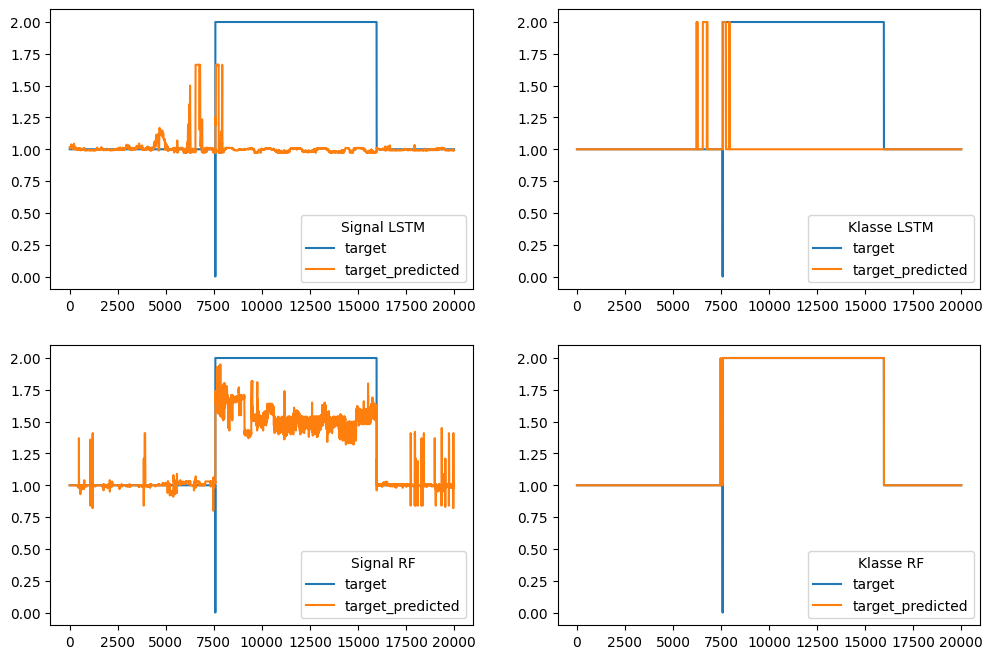

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=2)
Vorrausschauende_Instandhaltungs_KI.plot_signal_hat(saving=False, type='LSTM', name='LSTM', axis = axes[0,0])
Vorrausschauende_Instandhaltungs_KI.plot_class_hat(saving=False,  type='LSTM', name='LSTM', axis = axes[0,1])
Vorrausschauende_Instandhaltungs_KI.plot_signal_hat(saving=False, type='RF', name='RF', axis = axes[1,0])
Vorrausschauende_Instandhaltungs_KI.plot_class_hat(saving=False,  type='RF', name='RF', axis = axes[1,1])
fig.savefig('vorhersage_f10.png', format='png', dpi=300, transparent=True)
plt.show()

### Vergleich LSTM und Random Forest für 20 min

{0.0: 0, 1.0: 1, 2.0: 2}
Epoch 1/120
3750/3750 [==============================] - 8s 2ms/step - loss: 0.2153 - signal_out_loss: 0.0351 - class_out_loss: 0.1802 - class_out_acc: 0.9590 - val_loss: 0.0199 - val_signal_out_loss: 0.0017 - val_class_out_loss: 0.0182 - val_class_out_acc: 0.9985
Epoch 2/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2118 - signal_out_loss: 0.0340 - class_out_loss: 0.1778 - class_out_acc: 0.9502 - val_loss: 0.0189 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0175 - val_class_out_acc: 0.9985
Epoch 3/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2204 - signal_out_loss: 0.0339 - class_out_loss: 0.1864 - class_out_acc: 0.9502 - val_loss: 0.0194 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0179 - val_class_out_acc: 0.9985
Epoch 4/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2155 - signal_out_loss: 0.0346 - class_out_loss: 0.1809 - class_out_acc: 0.9502 - val_loss: 0.0199 - 

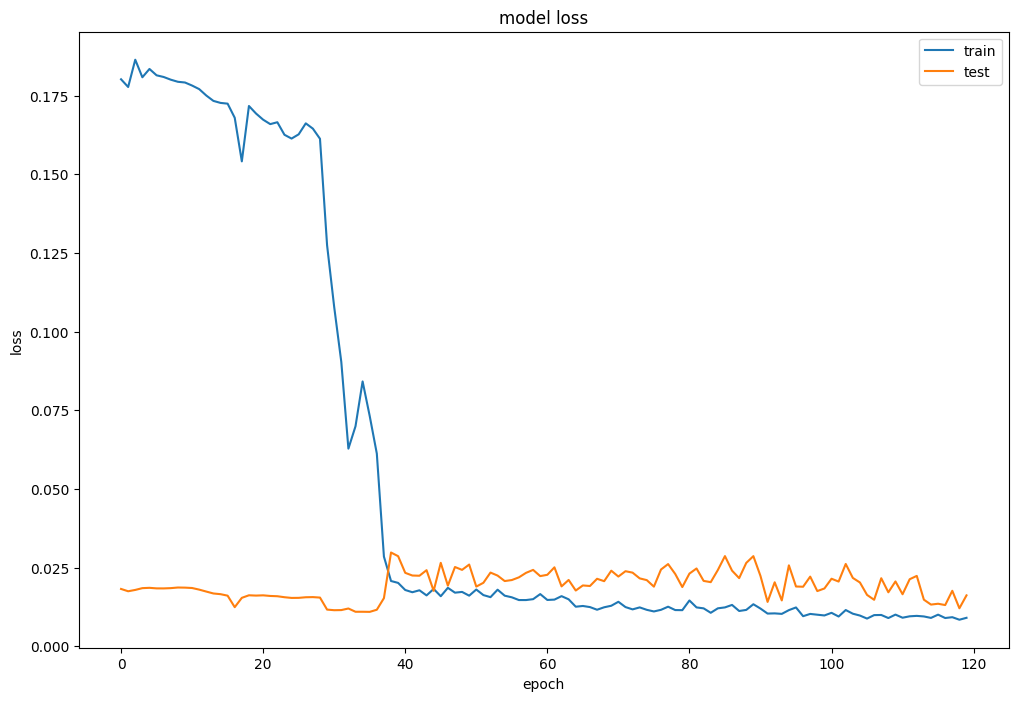

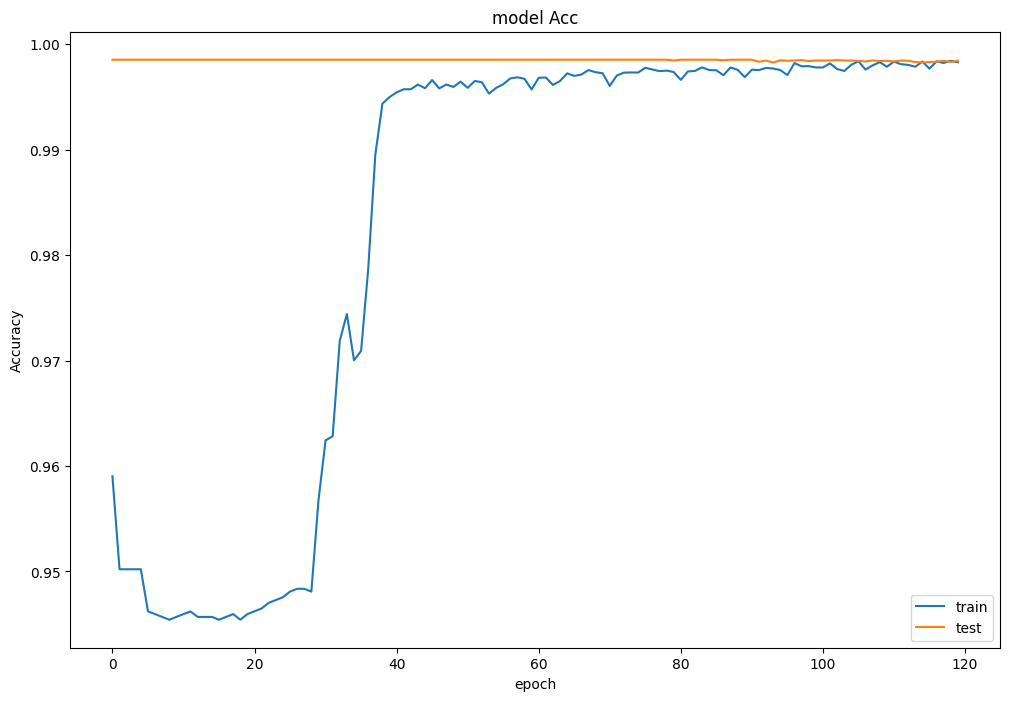

INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F10/assets


INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F10/assets


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 1, 919)]             0         []                            
                                                                                                  
 lstm_50 (LSTM)              (None, 1, 42)                161616    ['input_26[0][0]']            
                                                                                                  
 lstm_51 (LSTM)              (None, 42)                   14280     ['lstm_50[0][0]']             
                                                                                                  
 signal_out (Dense)          (None, 1)                    43        ['lstm_51[0][0]']             
                                                                                           

/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.9s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Confusion Matrix: [[    0     2     0]
 [    0 79344    24]
 [    0     2   114]]
Accuracy: 0.9996477367083512
Precision: 0.9996706977170766
Recall: 0.9996477367083512
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100building tree 25 of 100

building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.3s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
Vorrausschauende_Instandhaltungs_KI2 = KI(rohdaten = visualisierungs_daten, kodiertes_y = kodiertes_Y, vorhersage_zeitpunkt = 20)

Vorrausschauende_Instandhaltungs_KI2.LSTM_modell_trainieren(modell_name = "Pump_LSTM_F20",epoch=50)

print(Vorrausschauende_Instandhaltungs_KI2.modellzusammenfassung())

Vorrausschauende_Instandhaltungs_KI2.vorhersagen()

Vorrausschauende_Instandhaltungs_KI2.Random_forest_modell_trainieren()
  

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


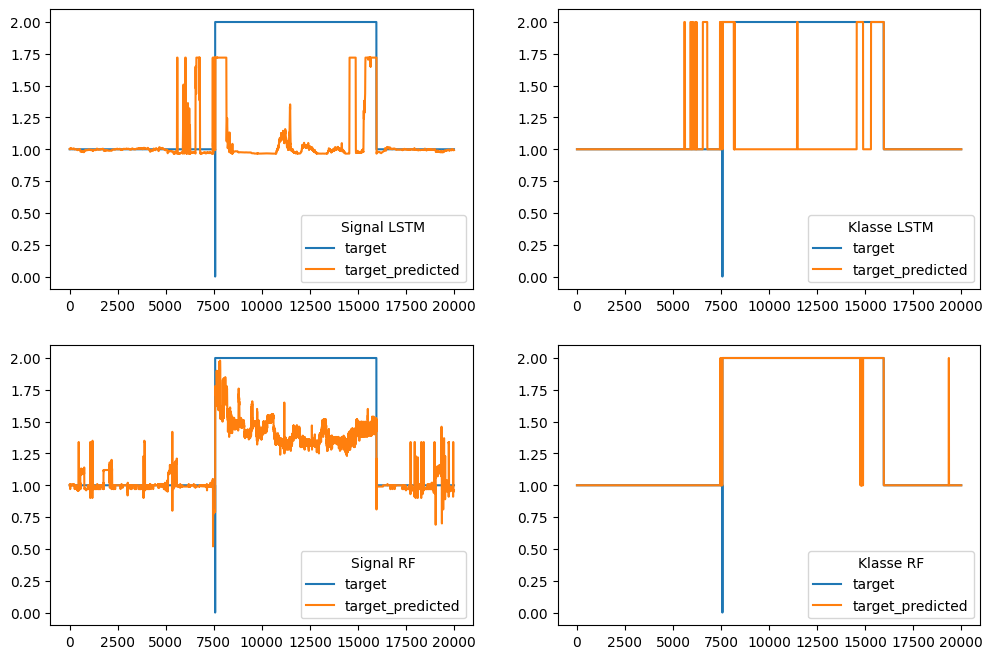

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2)
Vorrausschauende_Instandhaltungs_KI2.plot_signal_hat(saving=False, type='LSTM', name='LSTM', axis = axes[0,0])
Vorrausschauende_Instandhaltungs_KI2.plot_class_hat(saving=False,  type='LSTM', name='LSTM', axis = axes[0,1])
Vorrausschauende_Instandhaltungs_KI2.plot_signal_hat(saving=False, type='RF', name='RF', axis = axes[1,0])
Vorrausschauende_Instandhaltungs_KI2.plot_class_hat(saving=False,  type='RF', name='RF', axis = axes[1,1])
fig.savefig('vorhersage_f20.png', format='png', dpi=300, transparent=True)
plt.show()

### Vergleich LSTM und Random Forest für 30 min

{0.0: 0, 1.0: 1, 2.0: 2}
Epoch 1/120
3750/3750 [==============================] - 8s 2ms/step - loss: 0.1889 - signal_out_loss: 0.0386 - class_out_loss: 0.1502 - class_out_acc: 0.9560 - val_loss: 0.0148 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0133 - val_class_out_acc: 0.9985
Epoch 2/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.1350 - signal_out_loss: 0.0220 - class_out_loss: 0.1130 - class_out_acc: 0.9610 - val_loss: 0.0150 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0135 - val_class_out_acc: 0.9985
Epoch 3/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2268 - signal_out_loss: 0.0333 - class_out_loss: 0.1935 - class_out_acc: 0.9469 - val_loss: 0.0190 - val_signal_out_loss: 0.0015 - val_class_out_loss: 0.0175 - val_class_out_acc: 0.9985
Epoch 4/120
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2215 - signal_out_loss: 0.0328 - class_out_loss: 0.1887 - class_out_acc: 0.9469 - val_loss: 0.0200 - 

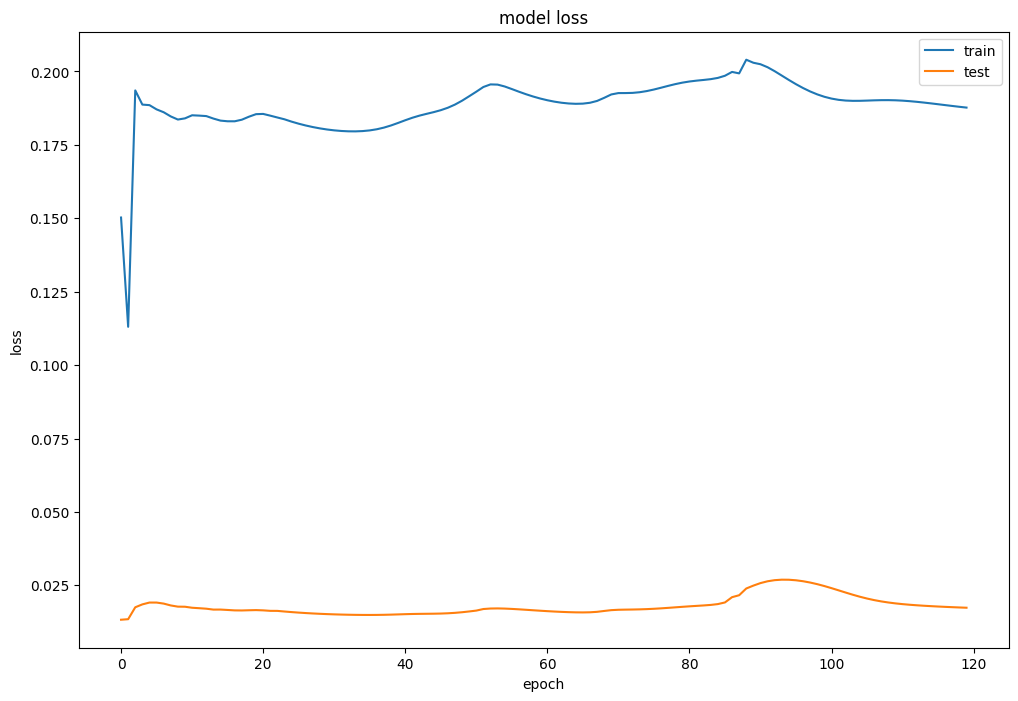

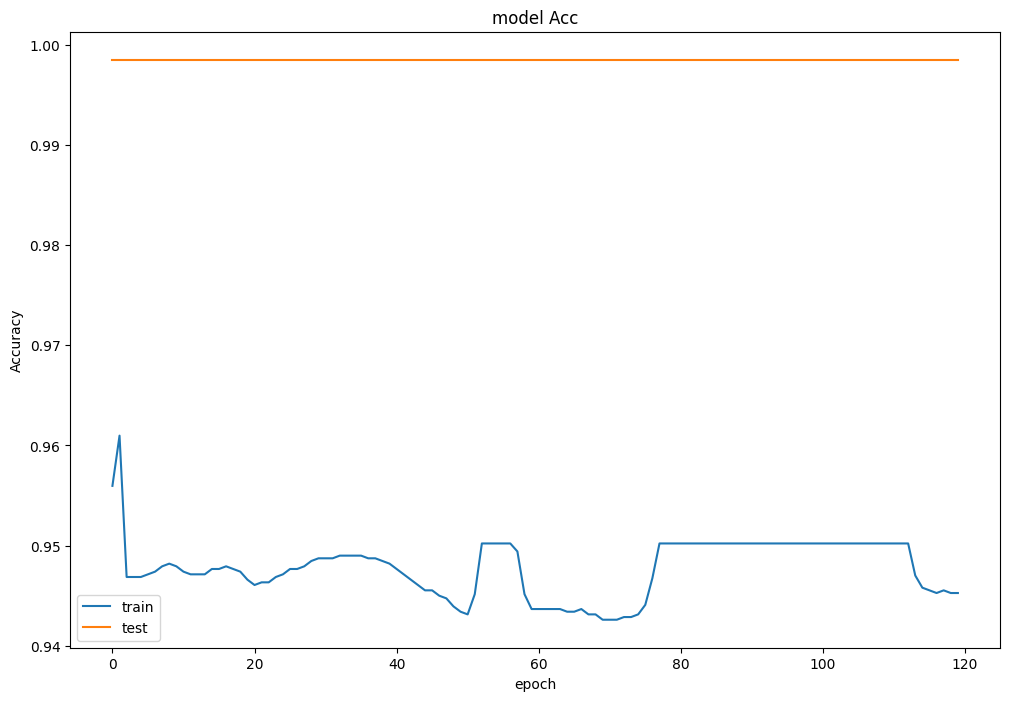

INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F30/assets


INFO:tensorflow:Assets written to: ./model/Pump_LSTM_F30/assets


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 1, 1379)]            0         []                            
                                                                                                  
 lstm_54 (LSTM)              (None, 1, 42)                238896    ['input_28[0][0]']            
                                                                                                  
 lstm_55 (LSTM)              (None, 42)                   14280     ['lstm_54[0][0]']             
                                                                                                  
 signal_out (Dense)          (None, 1)                    43        ['lstm_55[0][0]']             
                                                                                           

/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: [[    0     2     0]
 [    0 79353     5]
 [    0     2   114]]
Accuracy: 0.9998867582666465
Precision: 0.9998631788214686
Recall: 0.9998867582666465
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.0s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
/Users/jgruebel/.pyenv/versions/3.11.2/envs/jupyter_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
Vorrausschauende_Instandhaltungs_KI3 = KI(rohdaten = visualisierungs_daten, kodiertes_y = kodiertes_Y, vorhersage_zeitpunkt = 30)

Vorrausschauende_Instandhaltungs_KI3.LSTM_modell_trainieren(modell_name = "Pump_LSTM_F30",epoch=120)

print(Vorrausschauende_Instandhaltungs_KI3.modellzusammenfassung())

Vorrausschauende_Instandhaltungs_KI3.vorhersagen()

Vorrausschauende_Instandhaltungs_KI3.Random_forest_modell_trainieren()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


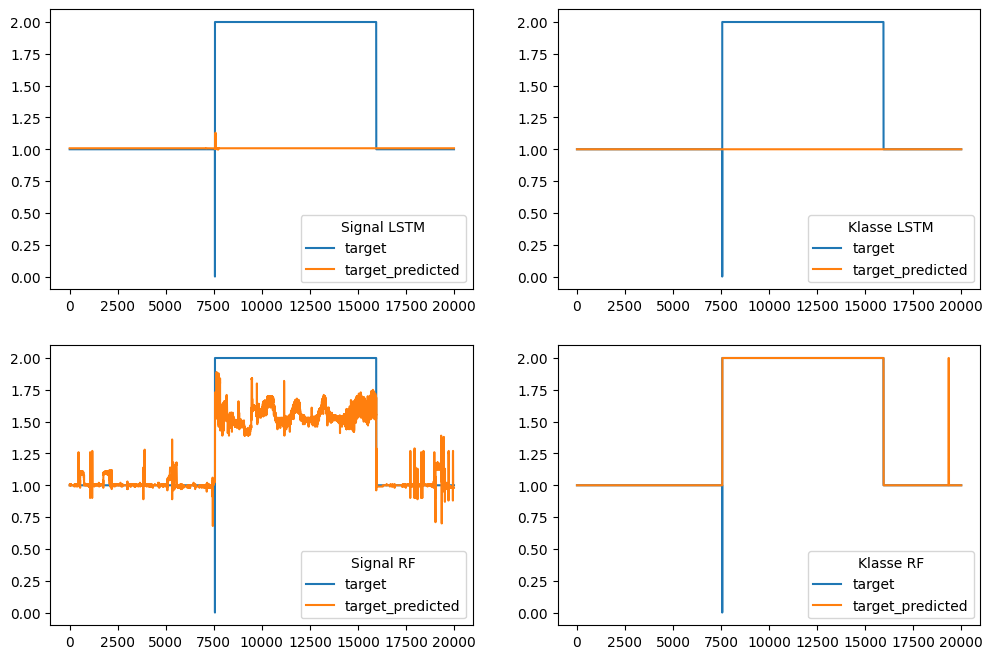

In [141]:
fig, axes = plt.subplots(nrows=2, ncols=2)
Vorrausschauende_Instandhaltungs_KI3.plot_signal_hat(saving=False, type='LSTM', name='LSTM', axis = axes[0,0])
Vorrausschauende_Instandhaltungs_KI3.plot_class_hat(saving=False,  type='LSTM', name='LSTM', axis = axes[0,1])
Vorrausschauende_Instandhaltungs_KI3.plot_signal_hat(saving=False, type='RF', name='RF', axis = axes[1,0])
Vorrausschauende_Instandhaltungs_KI3.plot_class_hat(saving=False,  type='RF', name='RF', axis = axes[1,1])
fig.savefig('vorhersage_f30.png', format='png', dpi=300, transparent=True)
plt.show()